In [47]:
%matplotlib ipympl
import os
import os.path as path
import numpy as np
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets
from ipywidgets import HBox, VBox
from IPython.display import clear_output
from IPython.display import display
from ipywidgets import IntSlider, Output
from itertools import product
from scipy.signal import find_peaks
import math
from mpl_toolkits.mplot3d import Axes3D

# Local module and scripts
from pyccapt.calibration.calibration_tools import tools, data_tools, variables, calibration, data_loadcrop
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.calibration_tools import dataset_path_qt
from pyccapt.calibration.leap_tools import ccapt_tools

In [27]:
# Disable showing logging in Jupyter notebook
import logging, sys
logging.disable(sys.maxsize)
save_fig=False
plot_fig=True 

In [28]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [65]:
tdc, det_diam, pulse_mode, flightPathLength_d, t0_d, max_tof = wd.dataset_tdc_selection()
display(tdc, det_diam, pulse_mode, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

FloatText(value=78.0, description='Detector diameter:')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=51.74, description='t0:')

$$\textbf{You can specify which dataset to use in below block}$$

In [66]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

flightPathLength = flightPathLength_d.value # mm 
# The initial value for t_0
t0 = t0_d.value # ns

dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]


variables.init()

variables.result_path = os.path.dirname(dataset_main_path) + '/mc_calibration/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = dataset_path

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

if tdc_model == 'leap_pos' or tdc_model == 'leap_pos':
    if tdc_model == 'leap_epos':
        data = ccapt_tools.epos_to_ccapt(filename)
    else:
        print('The file has to be epos. With pos information this tutorial cannot be run')
        data = ccapt_tools.pos_to_ccapt(filename)
else:
    data = data_tools.read_hdf5_through_pandas(filename)


In [67]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,31.253212,3579.636963,3579.636963,24305.0,809.497746,0.0,0.614449,2.324082,0,1
1,0.0,0.0,0.0,0.0,29.053112,3579.636963,3579.636963,24306.0,797.146488,0.0,1.945224,2.680653,1,1
2,0.0,0.0,0.0,0.0,748.741207,3579.636963,3579.636963,24730.0,3799.942362,0.0,1.827429,2.266776,424,1
3,0.0,0.0,0.0,0.0,29.427938,3579.636963,3579.636963,29708.0,787.812750,0.0,1.821061,-1.652327,4978,1
4,0.0,0.0,0.0,0.0,29.013504,3579.636963,3579.636963,30209.0,768.637782,0.0,-0.168735,-1.098367,501,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762980,0.0,0.0,0.0,0.0,29.038886,6329.787598,6329.787598,58547.0,596.728296,0.0,1.795592,-0.760898,67,1
1762981,0.0,0.0,0.0,0.0,29.484707,6329.787598,6329.787598,59740.0,593.134704,0.0,0.210122,-0.506204,1193,1
1762982,0.0,0.0,0.0,0.0,28.752708,6329.787598,6329.787598,59917.0,608.277168,0.0,2.492816,-2.056653,177,1
1762983,0.0,0.0,0.0,0.0,30.259675,6329.810547,6329.810547,14.0,620.168940,0.0,2.031184,2.273143,4294907393,1


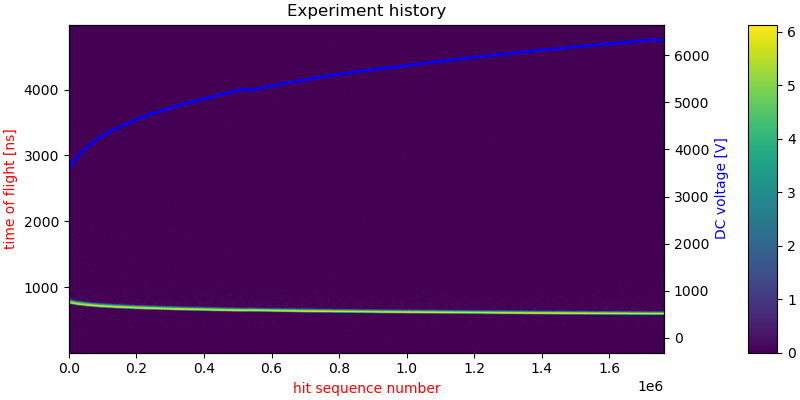

In [68]:
data_loadcrop.plot_crop_experimetn_history(data, save_name=variables.result_path + '//ex_hist_' + dataset_name)


In [69]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data['high_voltage (V)'].to_numpy()
if pulse_mode_ini == 'voltage':
    dld_pulseVoltage = data['pulse (V)'].to_numpy()
elif pulse_mode_ini == 'laser':
    dld_pulseVoltage = data['pulse (deg)'].to_numpy()
dld_t = data['t (ns)'].to_numpy()
dld_x = data['x_det (cm)'].to_numpy()
dld_y = data['y_det (cm)'].to_numpy()
mc = data['mc (Da)'].to_numpy()
# copy dld_t to a have a global version of that
variables.dld_t_calib = np.copy(dld_t)
# variables.mc_calib = np.copy(mc)
# variables.mc_calib_backup = np.copy(mc)

In [70]:
# peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(mc[mc < 150], 0.1, distance=100, percent=50, prominence=100, selector='rect', plot=True, label='mc', fig_name=figname+'_orig')

$$\textbf{Below plotted graph offers peak selection. You can select relevant peaks you want for computation.}$$

In [71]:
def mc_hist_plot(t_0, bin_size, prominence, distance, percent, selector, plot, figname, lim_mc):
    mc_seb_ini = mc_tools.tof2mc(dld_t, t_0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode=pulse_mode_ini)
    variables.mc_calib = np.copy(mc_seb_ini)
    variables.mc_calib_backup = np.copy(mc_seb_ini)
    mc = mc_seb_ini
    peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.mc_calib[variables.mc_calib < lim_mc], bin_size, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='mc', fig_name=figname+'_ini')
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
        print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

interact_manual(mc_hist_plot, t_0=widgets.FloatText(value=t0), bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_mc=widgets.IntText(value=150)
               ,percent=widgets.IntText(value=50), selector=fixed('rect'), plot=fixed(True), figname=fixed(figname));


interactive(children=(FloatText(value=51.74, description='t_0'), FloatText(value=0.1, description='bin_size'),…

In [72]:
bin_size=widgets.FloatText(value=0.1, description='bin size:')
prominence=widgets.IntText(value=100, description='peak prominance:')
distance=widgets.IntText(value=50, description='peak distance:')
lim_tof=widgets.IntText(value=150, description='lim tof/mc:')
percent=widgets.IntText(value=50, description='percent MRP:')

def hist_plot(figname, plot):
    
    with out:
        clear_output(True)
    
        bin_size_p = bin_size.value
        prominence_p = prominence.value
        distance_p = distance.value
        lim_tof_p = lim_tof.value
        percent_p = percent.value
        selector='rect'
        peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.mc_calib[variables.mc_calib < lim_tof_p], 
                                                bin_size_p, distance=distance_p, percent=percent_p, prominence=prominence_p,
                                                                    selector=selector, plot=plot, label='mc', fig_name=figname)
        index_max_ini = np.argmax(peaks_y_ini)
        variables.max_peak = peaks_ini[index_max_ini]
        variables.peak = peaks_ini
        mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
        print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
        for i in range(len(peaks_ini)):
                      print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides ({:.2f}%) are: ({:.2f}, {:.2f})'.format(percent_p, peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [73]:
sample_size_b = widgets.IntText(value=11, description='sample size:') 
index_fig_b = widgets.IntText(value=1, description='fig index:')
plot_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)

save_b = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
def bowl_correction(dld_x, dld_y, dld_highVoltage, figname=figname):
    with out:
        sample_size_p = sample_size_b.value
        index_fig_p = index_fig_b.value
        plot_p = plot_b.value
        save_p = save_b.value
        if plot_p:
            clear_output(True)

        calibration.bowl_correction_main(dld_x, dld_y, dld_highVoltage, det_diam.value, sample_size=sample_size_p, calibration_mode='mc',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p)


In [74]:
sample_size_v =widgets.IntText(value=100, description='sample size:') 
index_fig_v = widgets.IntText(value=1, description='fig index:')
plot_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='plot fig:'
)
save_v = widgets.Dropdown(
    options=[('False', False), ('True', True)],
    description='save fig:'
)
mode_v = widgets.Dropdown(
    options=[('ion_seq', 'ion_seq'), ('voltage', 'voltage')],
    description='sample mode:'
)
def vol_correction(dld_highVoltage, figname):
    with out:
        sample_size_p = sample_size_v.value
        index_fig_p = index_fig_v.value
        plot_p = plot_v.value
        save_p = save_v.value
        mode_p = mode_v.value
        if plot_p:
            clear_output(True)
        calibration.voltage_corr_main(dld_highVoltage, sample_size=sample_size_p, calibration_mode='mc',
                                        index_fig=index_fig_p, plot=plot_p, save=save_p, mode=mode_p)


In [75]:
pb_bowl = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
pb_vol = widgets.HTML(
    value=" ",
    placeholder='Status:',
    description='Status:',
)
plot_button = widgets.Button(
    description='plot hist',
)
plot_fdm_button = widgets.Button(
    description='plot FDM',
)
reset_button = widgets.Button(
    description='reset back correction',
)
save_button = widgets.Button(
    description='save correction',
)
bowl_button = widgets.Button(
    description='bowl correction',
)
vol_button = widgets.Button(
    description='voltage correction',
)
bin_fdm = widgets.IntText(value=256, description='bin FDM:')



@plot_button.on_click
def plot_on_click(b, figname=figname, plot=True):
    hist_plot(figname, plot)

@plot_fdm_button.on_click
def plot_fdm_on_click(b, save=True):
    with out:
        clear_output(True)
        mask_temporal = np.logical_and((variables.mc_calib > variables.selected_x1),
                                       (variables.mc_calib < variables.selected_x2))
        x = dld_x[mask_temporal]
        y = dld_y[mask_temporal]
        bin_fdm_p = bin_fdm.value
        bins = [bin_fdm_p, bin_fdm_p]

        calibration.plot_FDM(x, y, save, bins)
    
@reset_button.on_click
def reset_on_click(b, figname=figname, plot=True):
    variables.mc_calib = np.copy(variables.mc_calib_backup)
    
@save_button.on_click
def save_on_click(b, figname=figname, plot=True):
    variables.mc_calib_backup = np.copy(variables.mc_calib)   
    
@bowl_button.on_click
def bowl_on_click(b, dld_x=dld_x, dld_y=dld_y, dld_highVoltage=dld_highVoltage, figname=figname):
    pb_bowl.value = "<b>Starting...</b>"
    bowl_correction(dld_x, dld_y, dld_highVoltage, figname)  
    pb_bowl.value = "<b>Fnished</b>"
@vol_button.on_click
def vol_on_click(b, dld_highVoltage=dld_highVoltage, figname=figname):
    pb_vol.value = "<b>Starting...</b>"
    vol_correction(dld_highVoltage, figname)
    pb_vol.value = "<b>Fnished</b>"
    


tab1 = VBox(children=[bin_size, prominence, distance, lim_tof, percent, bin_fdm])
tab2 = VBox(children=[HBox(children=[sample_size_b, index_fig_b, plot_b, save_b]), bowl_button, pb_bowl])
tab3 = VBox(children=[HBox(children=[sample_size_v, index_fig_v, mode_v, plot_v, save_v]), vol_button, pb_vol])

tab = widgets.Tab(children=[tab1, tab2, tab3])
tab.set_title(0, 'tof/mc plot')
tab.set_title(1, 'bowl correction')
tab.set_title(2, 'voltage correction')



display(VBox(children=[tab,HBox(children=[plot_button, plot_fdm_button, save_button, reset_button])]))
out = Output()
display(out)

Output()

In [79]:
variables.mc_calib_backup = np.copy(variables.mc_calib)

In [80]:
def tof_his(bin_size, prominence, distance, percent, selector, plot, figname, lim_mc):
    variables.peaks_idx = []
    peaks_ini, peaks_y_ini, peak_widths_p_ini = tools.hist_plot(variables.mc_calib[variables.mc_calib < lim_mc], bin_size, distance=distance, percent=percent, prominence=prominence, selector=selector, plot=plot, label='mc', fig_name=figname)
    index_max_ini = np.argmax(peaks_y_ini)
    variables.max_peak = peaks_ini[index_max_ini]
    variables.peak = peaks_ini
    mrp = (peaks_ini[index_max_ini] / (peak_widths_p_ini[index_max_ini][2] - peak_widths_p_ini[index_max_ini][1]))
    print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
    for i in range(len(peaks_ini)):
        print('Peaks ', i, 'is at location and height: ({:.2f}, {:.2f})'.format(peaks_ini[i], peaks_y_ini[i]), 'peak window sides (half-maximum) are: ({:.2f}, {:.2f})'.format(peak_widths_p_ini[i][1], peak_widths_p_ini[i][2]))

In [81]:

interact_manual(tof_his, bin_size=widgets.FloatText(value=0.1)
               ,prominence=widgets.IntText(value=50), distance=widgets.IntText(value=100), lim_mc=widgets.IntText(value=150)
               ,percent=widgets.IntText(value=50), selector=fixed('rect'), plot=fixed(True), figname=fixed(figname+'_cor'));


interactive(children=(FloatText(value=0.1, description='bin_size'), IntText(value=50, description='prominence'…

In [82]:
data['mc_c (Da)'] = variables.mc_calib

In [83]:
data

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,30.374087,31.253212,3579.636963,3579.636963,24305.0,809.497746,0.0,0.614449,2.324082,0,1
1,0.0,0.0,0.0,28.482975,29.053112,3579.636963,3579.636963,24306.0,797.146488,0.0,1.945224,2.680653,1,1
2,0.0,0.0,0.0,733.700759,748.741207,3579.636963,3579.636963,24730.0,3799.942362,0.0,1.827429,2.266776,424,1
3,0.0,0.0,0.0,29.249036,29.427938,3579.636963,3579.636963,29708.0,787.812750,0.0,1.821061,-1.652327,4978,1
4,0.0,0.0,0.0,28.496723,29.013504,3579.636963,3579.636963,30209.0,768.637782,0.0,-0.168735,-1.098367,501,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762980,0.0,0.0,0.0,28.643858,29.038886,6329.787598,6329.787598,58547.0,596.728296,0.0,1.795592,-0.760898,67,1
1762981,0.0,0.0,0.0,28.824575,29.484707,6329.787598,6329.787598,59740.0,593.134704,0.0,0.210122,-0.506204,1193,1
1762982,0.0,0.0,0.0,28.671646,28.752708,6329.787598,6329.787598,59917.0,608.277168,0.0,2.492816,-2.056653,177,1
1762983,0.0,0.0,0.0,29.619693,30.259675,6329.810547,6329.810547,14.0,620.168940,0.0,2.031184,2.273143,4294907393,1


In [84]:
# save the new data
name_save_file = variables.result_path + '//' + dataset_name + '.h5'
data_tools.store_df_to_hdf(name_save_file, data, 'df')

In [85]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data, path=variables.result_path, name=dataset_name + '.pos')

In [25]:
# save data in csv format
data_tools.store_df_to_csv(data, variables.result_path + dataset_name + '.csv')